# Dual Momentum Strategy — Notebook Driver

Notebook driver for the Dual Momentum script.
Runs a baseline backtest, saves outputs to `../output/`, and compares a second configuration.


In [1]:
# Cell 2 — Imports, engine load, and paths (robust to where you launch Jupyter)
import os, sys, importlib.util, hashlib, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

# Search upwards from the current working directory for the engine file
ENGINE_NAMES = ("garvi_jesus_dual_momentum.py", "dual_momentum.py")
ENGINE_PATH = None

for base in [Path.cwd(), *Path.cwd().parents]:
    for name in ENGINE_NAMES:
        cand = base / name
        if cand.exists():
            ENGINE_PATH = cand.resolve()
            break
    if ENGINE_PATH is not None:
        break

assert ENGINE_PATH is not None, (
    "Engine file not found. Place 'garvi_jesus_dual_momentum.py' or "
    "'dual_momentum.py' in your project root and re-run."
)

# Project root is the folder that contains the engine file
PROJECT_ROOT = ENGINE_PATH.parent

# All notebook outputs go under <project_root>/output
OUTPUT_DIR = PROJECT_ROOT / "output"
try:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
except PermissionError:
    # As a last resort, write to a local ./output under the current working directory
    OUTPUT_DIR = Path.cwd() / "output"
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the engine module
spec = importlib.util.spec_from_file_location("dm_engine", str(ENGINE_PATH))
dm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dm)

# Short provenance hash for reproducibility
with open(ENGINE_PATH, "rb") as f:
    sha12 = hashlib.sha256(f.read()).hexdigest()[:12]

print("Engine file :", ENGINE_PATH)
print("Engine SHA  :", sha12)
print("Project root:", PROJECT_ROOT)
print("Output dir  :", OUTPUT_DIR)

Config = dm.Config  # convenience alias


AssertionError: Engine file not found. Place 'garvi_jesus_dual_momentum.py' or 'dual_momentum.py' in your project root and re-run.

In [ ]:
from pathlib import Path
out_dir = (Path('..') / 'output').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

TICKERS = ['SPY', 'QQQ', 'EFA', 'EEM']
START   = '2003-01-01'
END     = None  # latest

params = dict(
    top_k=1,
    lb_long_m=12,
    lb_short_m=3,
    cost_bps=1.0,        # modest friction
    slippage_bps=1.0,
    export_signals=str(out_dir / 'signals_default.csv'),
    export_metrics=str(out_dir / 'metrics_default.csv'),
    equity_png=str(out_dir / 'equity_curve_default.png'),
)
params


{'top_k': 1,
 'lb_long_m': 12,
 'lb_short_m': 3,
 'cost_bps': 1.0,
 'slippage_bps': 1.0,
 'export_signals': '/Users/jesusg/Desktop/output/signals_default.csv',
 'export_metrics': '/Users/jesusg/Desktop/output/metrics_default.csv',
 'equity_png': '/Users/jesusg/Desktop/output/equity_curve_default.png'}

In [ ]:
cfg = Config(
    tickers=TICKERS, start=START, end=END,
    top_k=params['top_k'],
    lb_long_m=params['lb_long_m'],
    lb_short_m=params['lb_short_m'],
    cost_bps=params['cost_bps'],
    slippage_bps=params['slippage_bps'],
    export_signals=params['export_signals'],
    export_metrics=params['export_metrics'],
    equity_png=params['equity_png'],
)

signals1, metrics1 = dm.run(cfg)
print("Baseline run complete.")


Baseline run complete.


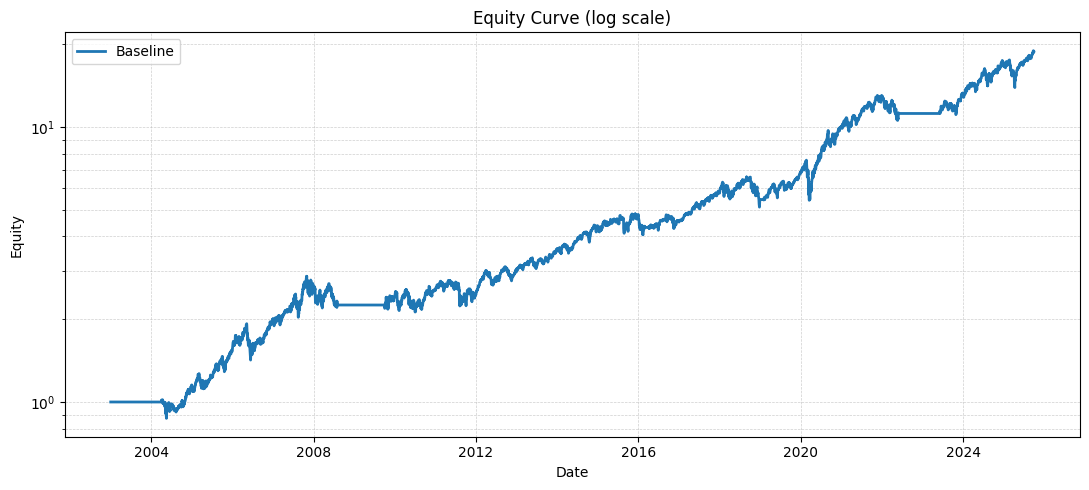

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,5))
plt.plot(signals1.index, signals1['equity'], linewidth=2, label='Baseline')
plt.yscale('log')
plt.title('Equity Curve (log scale)')
plt.xlabel('Date'); plt.ylabel('Equity')
plt.grid(True, which='both', ls='--', lw=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Count trading days spent in each asset (or CASH)
holding_days = signals1['chosen'].value_counts()
display(holding_days.to_frame('days').sort_values('days', ascending=False))


,days
chosen,
QQQ,2678
EEM,1237
CASH,901
SPY,484
EFA,421


In [ ]:
cfg2 = Config(
    tickers=['SPY','IWM','GLD','BND'],
    start='2008-01-01', end='2023-12-31',
    top_k=2,
    lb_long_m=12,
    lb_short_m=3,
    cost_bps=5.0,
    slippage_bps=5.0,
    export_signals=str(OUTPUT_DIR / 'run2_signals.csv'),
    export_metrics=str(OUTPUT_DIR / 'run2_metrics.csv'),
    equity_png=str(OUTPUT_DIR / 'run2_equity.png'),
)
cfg2


Config(tickers=['SPY', 'IWM', 'GLD', 'BND'], start='2008-01-01', end='2023-12-31', top_k=2, lb_long_m=12, lb_short_m=3, cost_bps=5.0, slippage_bps=5.0, export_signals='/Users/jesusg/output/run2_signals.csv', export_metrics='/Users/jesusg/output/run2_metrics.csv', equity_png='/Users/jesusg/output/run2_equity.png')

In [ ]:
import pandas as pd
from IPython.display import display

# Run the second configuration
signals2, metrics2 = dm.run(cfg2)

# Debug: Check what metrics2 actually contains
print(f"Type of metrics2: {type(metrics2)}")
if isinstance(metrics2, pd.DataFrame):
    print(f"Columns in metrics2: {metrics2.columns.tolist()}")
    print(f"Shape of metrics2: {metrics2.shape}")
elif isinstance(metrics2, dict):
    print(f"Keys in metrics2: {list(metrics2.keys())}")

# Convert metrics to DataFrame if they're dictionaries
if isinstance(metrics1, dict):
    metrics1 = pd.DataFrame([metrics1])
if isinstance(metrics2, dict):
    metrics2 = pd.DataFrame([metrics2])

# Sanity checks
assert isinstance(metrics1, pd.DataFrame), f"metrics1 must be DataFrame, got {type(metrics1)}"
assert isinstance(metrics2, pd.DataFrame), f"metrics2 must be DataFrame, got {type(metrics2)}"

# Check available columns first
print(f"Available columns in metrics1: {metrics1.columns.tolist()}")
print(f"Available columns in metrics2: {metrics2.columns.tolist()}")

# Define required columns (adjust based on what's actually available)
required_cols = {'CAGR', 'Sharpe', 'MaxDrawdown', 'Calmar', 'WinRate'}

# Check for missing columns
missing1 = required_cols - set(metrics1.columns)
missing2 = required_cols - set(metrics2.columns)

if missing1 or missing2:
    print(f"Warning: metrics1 missing columns: {missing1}")
    print(f"Warning: metrics2 missing columns: {missing2}")
    # Use only available columns
    available_cols = list(set(metrics1.columns) & set(metrics2.columns) & required_cols)
    print(f"Using available columns: {available_cols}")
else:
    available_cols = list(required_cols)

# Build comparison table
comparison = pd.concat(
    [
        metrics1[available_cols].assign(Run='Baseline'),
        metrics2[available_cols].assign(Run='Alt (top_k=2, higher costs)'),
    ],
    ignore_index=True,
    sort=False
).set_index('Run')

# Ensure numeric (avoids formatting/type errors)
for col in available_cols:
    comparison[col] = pd.to_numeric(comparison[col], errors='coerce')

# Pretty formatting (only for available columns)
fmt = {}
if 'CAGR' in available_cols:
    fmt['CAGR'] = '{:.2%}'
if 'MaxDrawdown' in available_cols:
    fmt['MaxDrawdown'] = '{:.2%}'
if 'WinRate' in available_cols:
    fmt['WinRate'] = '{:.2%}'
if 'Sharpe' in available_cols:
    fmt['Sharpe'] = '{:.2f}'
if 'Calmar' in available_cols:
    fmt['Calmar'] = '{:.2f}'

# Display the comparison
if fmt:
    display(comparison.style.format(fmt).set_caption("Metrics Comparison"))
else:
    display(comparison)
    print("No formatting applied - columns may have different names")

Type of metrics2: <class 'pandas.core.frame.DataFrame'>
Columns in metrics2: ['CAGR', 'Sharpe', 'MaxDrawdown', 'Calmar', 'WinRate']
Shape of metrics2: (1, 5)
Available columns in metrics1: ['CAGR', 'Sharpe', 'MaxDrawdown', 'Calmar', 'WinRate']
Available columns in metrics2: ['CAGR', 'Sharpe', 'MaxDrawdown', 'Calmar', 'WinRate']


,MaxDrawdown,WinRate,CAGR,Sharpe,Calmar
Run,,,,,
Baseline,-28.56%,54.78%,13.77%,0.76,0.48
"Alt (top_k=2, higher costs)",-32.63%,55.50%,3.86%,0.35,0.12


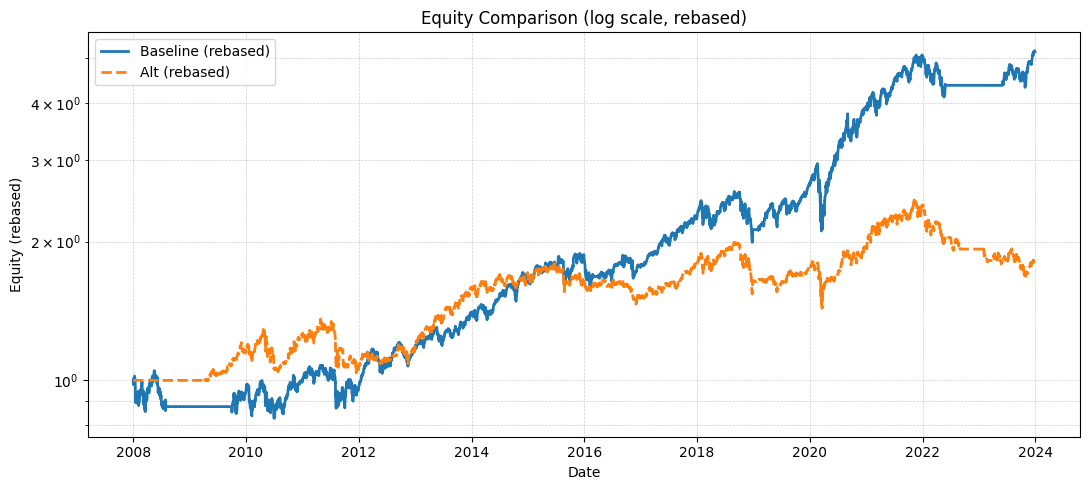

In [ ]:

s1 = signals1['equity']; s2 = signals2['equity']
start = max(s1.index.min(), s2.index.min())
end   = min(s1.index.max(), s2.index.max())
s1a = s1.loc[start:end].dropna()
s2a = s2.loc[start:end].dropna()

if len(s1a) and len(s2a):
    s1r = s1a / s1a.iloc[0]
    s2r = s2a / s2a.iloc[0]

    plt.figure(figsize=(11,5))
    plt.plot(s1r.index, s1r, lw=2, label='Baseline (rebased)')
    plt.plot(s2r.index, s2r, lw=2, ls='--', label='Alt (rebased)')
    plt.yscale('log')
    plt.title('Equity Comparison (log scale, rebased)')
    plt.xlabel('Date'); plt.ylabel('Equity (rebased)')
    plt.grid(True, which='both', ls='--', lw=0.5, alpha=0.6)
    plt.legend(); plt.tight_layout(); plt.show()


## Next steps
- Add unit tests for weight alignment, turnover, and metrics.
- Include a benchmark (e.g., SPY buy & hold) and export a comparison table.
- Add CI (GitHub Actions) to run tests and linting on each push.
- Optional: YAML config and a data cache layer to avoid repeated downloads.
